Setup
------
To run this tutorial, you'll need to run the following command in `terminal` (Mac) or `powershell` (Windows) to install `mplstereonet` from the loop3d server:

```bash
% conda install -c loop3d mplstereonet 
```


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import pandas as pd
import mplstereonet as mpls
import numpy.random as random
from past.utils import old_div
%matplotlib inline

Functions
---------

The following are some helper functions from the `pmagpy` package (Tauxe _et al._ 2016). Rather than installing the whole package, I'm including these functions here. 

A function is like a sub-program: it's a small chunk of code (the function definition) that Python runs through whenever it sees the function name (called the "function call"). Function definitions in Python are always given as follows:
```Python
def function_name(parameters):
    """
    docstring
    """
    commands
    more commands
    ...
    even more
    return output_stuff
```
Note that functions need to be indented. That's how Python recognizes what's in a function.

I like to think of a function as a machine that takes some input stuff (variables, numbers, text, etc.: the `parameters`), does something to it, and gives you back some output stuff (identified here as `output_stuff`). Math functions like numpy's `np.sin` and `np.cos` are examples - they take as input a number or a list of numbers, and return as output a different number or list of numbers. Neither the input nor the output are always necessary. For example, you can have a function that puts the latest plot on the screen (matplotlib's plt.show() function). 

The *docstring* is what you see when you ask for help on that function.

You can set a parameter's default value in the function definition (e.g. `k = 20`), in which case you don't need to specify it when you call the function, unless you want to set that parameter differently. 

A function call looks something like this:
```
output = function_name(parameters)
```
This stores the output from function_name in a variable called `output`. Here's a concrete example with np.sin from the Numpy package:
```
r = np.sin(0.35)
```

You could also write: 
```
r = np.sin(x=0.35)
```
In the first example, the `x` parameter was set *by location*, meaning that Python assumed that, because `x` is the first parameter of `np.sin`, that was what I wanted to set to be 0.35. In the second, I specifically requested to set `x` to 0.35, which is called a *keyword parameter*.

So: in the next block are a bunch of function definitions. Here's what a few of them take as input, and what those output:

__`fishrot`__ pull a set of random vectors from a Fisher (spherical normal) distribution with a particular mean direction: 

|Input|&rarr;|Function|&rarr;|Output|
|-----|------|--------|------|------|
|precision parameter `k` |||||
|number of vectors `n` |||||
|trend (a.k.a. declination) of mean vector `dec` | &rarr; | _`fishrot`_ | &rarr; | one or two lists of vectors, depending on format
|plunge (a.k.a. inclination) of mean `inc` |||||
|list format `di_block` |||||

__`fshdev`__ pull a random vector or set of random vectors from a Fisher (spherical normal) distribution with mean 000/00$^\circ$: 

|Input|&rarr;|Function|&rarr;|Output|
|-----|------|--------|------|------|
|precision parameter (or list thereof) `k` | &rarr; | _`fshdev`_ | &rarr; | declination and inclination of vector (or list thereof)


In [7]:
def fishrot(k=20, n=100, dec=0, inc=90, di_block=True):
    """
    Generates Fisher distributed unit vectors from a specified distribution
    using the pmag.py fshdev and dodirot functions.

    Parameters
    ----------
    k : kappa precision parameter (default is 20)
    n : number of vectors to determine (default is 100)
    dec : mean declination of distribution (default is 0)
    inc : mean inclination of distribution (default is 90)
    di_block : this function returns a nested list of [dec,inc,1.0] as the default
    if di_block = False it will return a list of dec and a list of inc

    Returns
    ---------
    di_block : a nested list of [dec,inc,1.0] (default)
    dec, inc : a list of dec and a list of inc (if di_block = False)

    Examples
    --------
    >>> fishrot(k=20, n=5, dec=40, inc=60)
    [[44.766285502555775, 37.440866867657235, 1.0],
     [33.866315796883725, 64.732532250463436, 1.0],
     [47.002912770597163, 54.317853800896977, 1.0],
     [36.762165614432547, 56.857240672884252, 1.0],
     [71.43950604474395, 59.825830945715431, 1.0]]
    """
    directions = []
    declinations = []
    inclinations = []
    if di_block == True:
        for data in range(n):
            d, i = fshdev(k)
            drot, irot = dodirot(d, i, dec, inc)
            directions.append([drot, irot, 1.])
        return directions
    else:
        for data in range(n):
            d, i = fshdev(k)
            drot, irot = dodirot(d, i, dec, inc)
            declinations.append(drot)
            inclinations.append(irot)
        return declinations, inclinations

def fshdev(k):
    """
    Generate a random draw from a Fisher distribution with mean declination
    of 0 and inclination of 90 with a specified kappa.

    Parameters
    ----------
    k : kappa (precision parameter) of the distribution
        k can be a single number or an array of values

    Returns
    ----------
    dec, inc : declination and inclination of random Fisher distribution draw
               if k is an array, dec, inc are returned as arrays, otherwise, single values
    """
    k = np.array(k)
    if len(k.shape) != 0:
        n = k.shape[0]
    else:
        n = 1
    R1 = random.random(size=n)
    R2 = random.random(size=n)
    L = np.exp(-2 * k)
    a = R1 * (1 - L) + L
    fac = np.sqrt(-np.log(a)/(2 * k))
    inc = 90. - np.degrees(2 * np.arcsin(fac))
    dec = np.degrees(2 * np.pi * R2)
    if n == 1:
        return dec[0], inc[0]  # preserve backward compatibility
    else:
        return dec, inc


def dodirot(D, I, Dbar, Ibar):
    """
    Rotate a direction (declination, inclination) by the difference between
    dec=0 and inc = 90 and the provided desired mean direction

    Parameters
    ----------
    D : declination to be rotated
    I : inclination to be rotated
    Dbar : declination of desired mean
    Ibar : inclination of desired mean

    Returns
    ----------
    drot, irot : rotated declination and inclination
    """
    d, irot = dogeo(D, I, Dbar, 90. - Ibar)
    drot = d - 180.
    if drot < 360.:
        drot = drot + 360.
    if drot > 360.:
        drot = drot - 360.
    return drot, irot

def dogeo(dec, inc, az, pl):
    """
    Rotates declination and inclination into geographic coordinates using the
    azimuth and plunge of the X direction (lab arrow) of a specimen.

    Parameters
    ----------
    dec : declination in specimen coordinates
    inc : inclination in specimen coordinates

    Returns
    -------
    rotated_direction : tuple of declination, inclination in geographic coordinates

    Examples
    --------
    >>> pmag.dogeo(0.0,90.0,0.0,45.5)
    (180.0, 44.5)
    """
    A1, A2, A3 = [], [], []  # set up lists for rotation vector
    # put dec inc in direction list and set  length to unity
    Dir = [dec, inc, 1.]
    X = dir2cart(Dir)  # get cartesian coordinates
#
#   set up rotation matrix
#
    A1 = dir2cart([az, pl, 1.])
    A2 = dir2cart([az + 90., 0, 1.])
    A3 = dir2cart([az - 180., 90. - pl, 1.])
#
# do rotation
#
    xp = A1[0] * X[0] + A2[0] * X[1] + A3[0] * X[2]
    yp = A1[1] * X[0] + A2[1] * X[1] + A3[1] * X[2]
    zp = A1[2] * X[0] + A2[2] * X[1] + A3[2] * X[2]
#
# transform back to dec,inc
#
    Dir_geo = cart2dir([xp, yp, zp])
    return Dir_geo[0], Dir_geo[1]    # send back declination and inclination

def dir2cart(d):
    """
    Converts a list or array of vector directions in degrees (declination,
    inclination) to an array of the direction in cartesian coordinates (x,y,z)

    Parameters
    ----------
    d : list or array of [dec,inc] or [dec,inc,intensity]

    Returns
    -------
    cart : array of [x,y,z]

    Examples
    --------
    >>> pmag.dir2cart([200,40,1])
    array([-0.71984631, -0.26200263,  0.64278761])
    """
    ints = np.ones(len(d)).transpose()  # get an array of ones to plug into dec,inc pairs
    d = np.array(d)
    rad = np.pi/180.
    if len(d.shape) > 1:  # array of vectors
        decs, incs = d[:, 0] * rad, d[:, 1] * rad
        if d.shape[1] == 3:
            ints = d[:, 2]  # take the given lengths
    else:  # single vector
        decs, incs = np.array(float(d[0])) * rad, np.array(float(d[1])) * rad
        if len(d) == 3:
            ints = np.array(d[2])
        else:
            ints = np.array([1.])
    cart = np.array([ints * np.cos(decs) * np.cos(incs), ints *
                     np.sin(decs) * np.cos(incs), ints * np.sin(incs)]).transpose()
    return cart

def cart2dir(cart):
    """
    Converts a direction in cartesian coordinates into declination, inclinations

    Parameters
    ----------
    cart : input list of [x,y,z] or list of lists [[x1,y1,z1],[x2,y2,z2]...]

    Returns
    -------
    direction_array : returns an array of [declination, inclination, intensity]

    Examples
    --------
    >>> pmag.cart2dir([0,1,0])
    array([ 90.,   0.,   1.])
    """
    cart = np.array(cart)
    rad = old_div(np.pi, 180.)  # constant to convert degrees to radians
    if len(cart.shape) > 1:
        Xs, Ys, Zs = cart[:, 0], cart[:, 1], cart[:, 2]
    else:  # single vector
        Xs, Ys, Zs = cart[0], cart[1], cart[2]
    if np.iscomplexobj(Xs):
        Xs = Xs.real
    if np.iscomplexobj(Ys):
        Ys = Ys.real
    if np.iscomplexobj(Zs):
        Zs = Zs.real
    Rs = np.sqrt(Xs**2 + Ys**2 + Zs**2)  # calculate resultant vector length
    # calculate declination taking care of correct quadrants (arctan2) and
    # making modulo 360.
    Decs = (old_div(np.arctan2(Ys, Xs), rad)) % 360.
    try:
        # calculate inclination (converting to degrees) #
        Incs = old_div(np.arcsin(old_div(Zs, Rs)), rad)
    except:
        print('trouble in cart2dir')  # most likely division by zero somewhere
        return np.zeros(3)

    return np.array([Decs, Incs, Rs]).transpose()  # return the directions list

#### Now try this:
1. The `dir2cart` function changes trend and plunge into Cartesian (X, Y, Z) coordinates. What are the inputs to and outputs from the `dir2cart` function? 
2. Try changing 000/00$^\circ$ to Cartesian coordinates. Now try converting 135/30$^\circ$ to Cartesian.
3. Try changing 135/30$^\circ$ to Cartesian and back to trend/plunge using `dir2cart` and `cart2dir`.
4. Try getting some help on the `dodirot` function ("do D-I rot" = do a rotation using a declination and inclination).
5. Use the `fishrot` function to pull 50 random vectors from a Fisher distribution with a dispersion parameter of 100 and a mean vector of 135/30$^\circ$. Graph histograms of the declination and inclination of these vectors, and find the mean declination and mean inclination.
6. Do the same as the above, but with a dispersion parameter of 10. What's different about the histograms?

To take the vector mean of vectors from a Fisher distribution, you need to convert the vectors to Cartesian coordinates, sum up each of the components separately (that is, sum the Xs, sum the Ys, and sum the Zs), and then convert the sum into a trend/plunge.

#### Now try this:
1. (This is a challenge) Finish the function definition below to make a function that calculates the vector mean.

In [8]:
def vector_mean (di_block):
    """
    Calculates a vector mean of a list of vectors each of which has the form [dec, inc, 1.0].

    Parameters
    ----------
    di_block : input list of vectors of the form [[dec1, inc1, 1.0],[dec2, inc2, 1.0]...]

    Returns
    -------
    direction_array : returns an array of [declination, inclination, 1.0]

    Examples
    --------
    
    """
    D = dir2cart(di_block) # Convert input list to Cartesian coordinates
    # more commands go here
    return direction_array

In the example below, we draw two sets of vectors from different Fisher distributions. We then print their trends and plunges.

#### Now Try This
1. What do the declination and inclination histograms look like?

In [9]:
bimodal_data=fishrot(k=50,n=25,dec=33,inc=41) + fishrot(k=100,n=30,dec=250,inc=68)
trends = np.array(bimodal_data)[:,0]
plunges = np.array(bimodal_data)[:,1]
for di in bimodal_data:
    print ('%7.1f %7.1f'%(di[0],di[1]))

   22.4    28.5
   18.6    45.7
   32.1    40.0
   32.5    28.1
   30.8    31.8
   46.6    35.5
   12.9    45.4
   38.1    39.7
   23.5    43.2
   47.1    40.5
   43.9    31.0
   26.0    42.6
   27.0    35.8
    6.7    27.3
   24.2    39.2
   33.5    42.0
   49.1    30.7
   32.3    42.1
  357.4    41.8
   39.0    30.3
   40.3    48.6
   12.3    52.4
   11.7    42.3
   44.0    36.0
   22.9    34.0
  243.1    68.7
  251.5    65.9
  245.5    68.3
  253.2    55.1
  249.7    65.5
  244.5    61.1
  226.5    63.5
  274.2    72.4
  271.9    67.3
  241.1    63.3
  230.0    74.2
  229.0    70.2
  247.6    76.1
  255.2    69.2
  270.6    72.6
  234.8    63.3
  269.0    67.1
  257.3    60.6
  267.2    67.1
  280.5    78.0
  233.4    72.5
  240.1    70.1
  236.7    57.3
  242.7    59.1
  222.3    68.3
  236.0    65.5
  248.0    58.7
  262.6    60.6
  254.6    68.5
  240.9    57.4


What do the data look like on a stereonet? It's much easier to see the mean vectors and the bimodal nature of the data here.

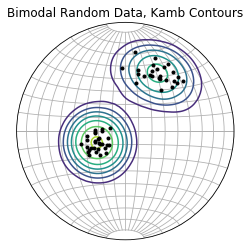

In [10]:
fig, ax = mpls.subplots()

cax = ax.density_contour(plunges, trends, measurement='lines', method='linear_kamb')

ax.line(plunges, trends, 'k.')
ax.grid(True)
#fig.colorbar(cax)
ax.set_title('Bimodal Random Data, Kamb Contours')
ax.set_azimuth_ticks([])

plt.show()